## 초기 EDA

### 신고/차단 관련 데이터 명세

In [24]:
import os
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import koreanize_matplotlib
from google.cloud import storage
import gcsfs

In [3]:
gcs_parquet_path = "gs://sprintda05_final_project/votes/accounts_timelinereport.parquet"
accounts_timelinereport = pd.read_parquet(gcs_parquet_path, engine='pyarrow').drop(columns='id')

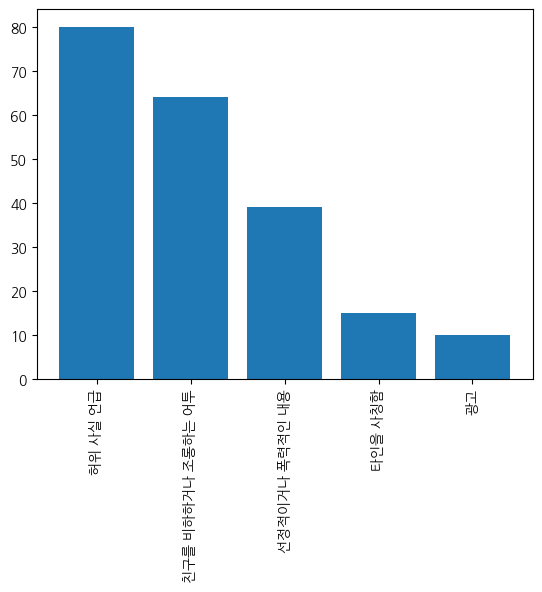

In [32]:
fig, ax = plt.subplots()
# fig.patch.set_facecolor('none')
ax.bar(accounts_timelinereport['reason'].value_counts().reset_index()['reason'], height=accounts_timelinereport['reason'].value_counts().reset_index()['count'])
plt.xticks(rotation=90)
plt.show()

In [3]:
gcs_parquet_path = "gs://sprintda05_final_project/votes/accounts_blockrecord.parquet"
accounts_blockrecord = pd.read_parquet(gcs_parquet_path, engine='pyarrow').drop(columns='id')

In [33]:
gcs_parquet_path = "gs://sprintda05_final_project/votes/accounts_user.parquet"
accounts_user = pd.read_parquet(gcs_parquet_path, engine='pyarrow')

In [106]:
# 신고내역과 차단내역(accounts_blockrecord) 간의 관계 조사
df_merge_block = accounts_timelinereport.merge(accounts_blockrecord, left_on=['user_id','reported_user_id'], right_on=['user_id','block_user_id'],suffixes=('_report', '_block'))
df_merge_block

,reason_report,created_at_report,reported_user_id,user_id,user_question_record_id,reason_block,created_at_block,block_user_id
0,허위 사실 언급,2023-05-12 02:48:56,1150928,1137878,26226336,모르는 사람임,2023-05-14 02:55:26,1150928


In [ ]:
# block_user_id_list 여러 행으로 explode
accounts_user_nan = accounts_user.replace('[]', np.nan)
accounts_user_dropna = accounts_user_nan.dropna()
accounts_user_dropna['block_user_id_list'] = accounts_user_dropna['block_user_id_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
accounts_user_explode = accounts_user_dropna[['id','block_user_id_list']].explode('block_user_id_list')
accounts_user_explode

/tmp/ipykernel_226/177197795.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accounts_user_dropna['block_user_id_list'] = accounts_user_dropna['block_user_id_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


,id,block_user_id_list
162,837615,839155
208,837689,834325
285,837784,834325
287,837786,1158705
287,837786,1108926
...,...,...
668524,1574460,1576077
668524,1574460,1576581
668575,1574512,1005876
670207,1576284,1349412


In [125]:
# 신고내역과 차단내역(block_user_id_list) 간의 관계 조사
df_merge_ban = accounts_timelinereport.merge(accounts_user_explode, left_on=['user_id','reported_user_id'], right_on=['id','block_user_id_list'],suffixes=('_report', '_ban'))
df_merge_ban

,reason,created_at,reported_user_id,user_id,user_question_record_id,id,block_user_id_list


In [ ]:
# hide_user_id_list 여러 행으로 explode
accounts_user_dropna['hide_user_id_list'] = accounts_user_dropna['hide_user_id_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
accounts_user_explode = accounts_user_dropna[['id','hide_user_id_list']].explode('hide_user_id_list')
accounts_user_explode

/tmp/ipykernel_226/1497952159.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accounts_user_dropna['hide_user_id_list'] = accounts_user_dropna['hide_user_id_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


,id,hide_user_id_list
162,837615,837661
208,837689,838168
208,837689,837745
285,837784,837684
285,837784,839155
...,...,...
668575,1574512,1129856
670207,1576284,1349412
672023,1578333,1578352
672023,1578333,1578399


In [127]:
# 신고내역과 숨김내역(hide_user_id_list) 간의 관계 조사
df_merge_hide = accounts_timelinereport.merge(accounts_user_explode, left_on=['user_id','reported_user_id'], right_on=['id','hide_user_id_list'],suffixes=('_report', '_hide'))
df_merge_hide

,reason,created_at,reported_user_id,user_id,user_question_record_id,id,hide_user_id_list


In [161]:
ban_status_total = accounts_user['ban_status'].value_counts().reset_index()
ban_status_total

,ban_status,count
0,N,668432
1,W,7855
2,NB,608
3,RB,190


In [155]:
import matplotlib.pyplot as plt

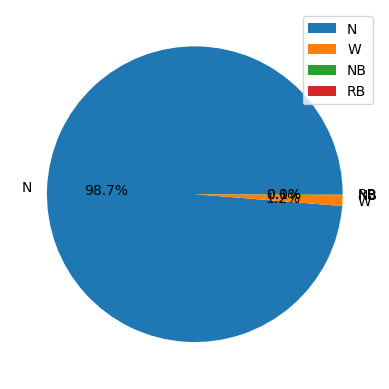

In [172]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('none')
ax.pie(ban_status_total['count'], labels=ban_status_total['ban_status'], autopct='%1.1f%%',)
ax.legend()
plt.show()

In [173]:
# 총 신고 횟수와 ban_status 간의 관계

report_cnt = accounts_timelinereport['reported_user_id'].value_counts().reset_index()
ban_status = accounts_user[['id','ban_status']]
merge_report_ban = pd.merge(report_cnt, ban_status, left_on='reported_user_id', right_on='id')
report_ban_total = merge_report_ban['ban_status'].value_counts().reset_index()

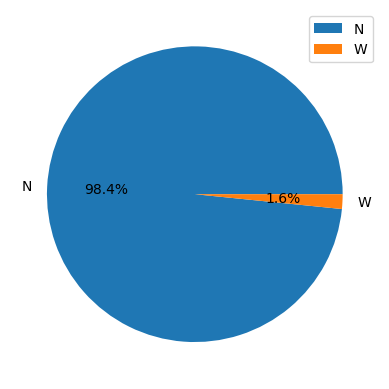

In [174]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('none')
ax.pie(report_ban_total['count'], labels=report_ban_total['ban_status'], autopct='%1.1f%%',)
ax.legend()
plt.show()

In [175]:
# 총 차단 횟수와 ban_status 간의 관계

block_cnt = accounts_blockrecord['block_user_id'].value_counts().reset_index()
ban_status = accounts_user[['id','ban_status']]
merge_block_ban = pd.merge(block_cnt, ban_status, left_on='block_user_id', right_on='id')
block_ban_total = merge_block_ban['ban_status'].value_counts().reset_index()

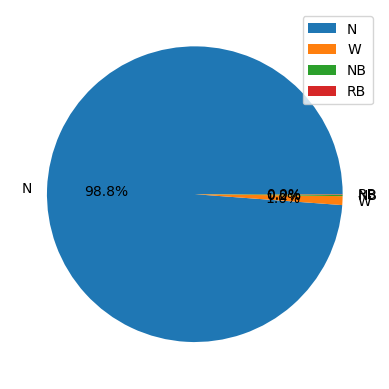

In [ ]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('none')
ax.pie(block_ban_total['count'], labels=block_ban_total['ban_status'], autopct='%1.1f%%',)
ax.legend()
plt.show()

In [150]:
merge_block_ban[merge_block_ban['ban_status']=='NB']['count'].value_counts()

count
1    23
4     1
3     1
2     1
Name: count, dtype: int64

In [151]:
merge_block_ban[merge_block_ban['ban_status']=='RB']['count'].value_counts()

count
1     5
2     2
11    1
Name: count, dtype: int64

### 친구는 쌍방일까?

In [6]:
accounts_user_frnd = accounts_user.copy()
accounts_user_frnd['friend_id_list'] = accounts_user_frnd['friend_id_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
accounts_user_frnd_explode = accounts_user_frnd[['id','friend_id_list']].explode('friend_id_list')
accounts_user_frnd_explode

,id,friend_id_list
0,831956,1292473
0,831956,913158
0,831956,1488461
0,831956,1064695
0,831956,1043565
...,...,...
677082,1583731,1583673
677083,1583732,1583673
677083,1583732,1583730
677083,1583732,1583731


In [7]:
accounts_user_frnd_explode = accounts_user_frnd_explode.dropna()
accounts_user_frnd_explode.shape

(36107386, 2)

In [8]:
accounts_user_frnd_explode = accounts_user_frnd_explode.reset_index(drop=True)

In [ ]:
pairs = set(zip(accounts_user_frnd_explode['id'], accounts_user_frnd_explode['friend_id_list']))

# 쌍방이어야 하는 반대 방향 쌍 생성
reverse_pairs = set((b, a) for (a, b) in pairs)

# 쌍방 아닌 것만 추출
non_mutual = pairs - reverse_pairs

In [12]:
print("쌍방 아닌 관계의 개수:")
print(len(non_mutual))

쌍방 아닌 관계의 개수:
183902


### 데이터 품질 검사

In [ ]:
# GCS 파일 시스템 객체 생성
fs = gcsfs.GCSFileSystem()

# GCS 버킷 내 모든 parquet 파일 경로 가져오기
parquet_paths = fs.glob("sprintda05_final_project/**/*.parquet")

# 파일명 기반으로 DataFrame 딕셔너리 만들기
dataframes = {}

for path in parquet_paths:
    df = pd.read_parquet(f"gs://{path}", engine="pyarrow")
    if 'id' in df.columns:
        df = df.drop(columns='id')
    
    # 파일명(확장자 포함)을 key로 사용
    filename = path.split("/")[-1]
    dataframes[filename] = df

In [8]:
# enumerate로 사용하기
for idx, (filename, df) in enumerate(dataframes.items()):
    print(f"[{idx}] {filename}: {df.shape}")
    # 원하는 작업 수행
    # print(df.replace('[]', np.nan).isna().sum())
    for col in df.columns:
        count = (df[col] == '[]').sum()
        print(f"{col}\t{count}")
    print()

[0] device_properties.parquet: (252380, 3)
device_id	0
device_model	0
device_vendor	0

[1] hackle_events.parquet: (11441319, 10)
event_id	0
event_datetime	0
event_key	0
session_id	0
item_name	0
page_name	0
friend_count	0
votes_count	0
heart_balance	0
question_id	0

[2] hackle_properties.parquet: (525350, 7)
session_id	0
user_id	0
language	0
osname	0
osversion	0
versionname	0
device_id	0

[3] user_properties.parquet: (230819, 5)
user_id	0
class	0
gender	0
grade	0
school_id	0

[4] accounts_attendance.parquet: (349637, 2)
attendance_date_list	20945
user_id	0

[5] accounts_blockrecord.parquet: (19482, 4)
reason	0
created_at	0
block_user_id	0
user_id	0

[6] accounts_failpaymenthistory.parquet: (163, 4)
productId	0
phone_type	0
created_at	0
user_id	0

[7] accounts_friendrequest.parquet: (17147175, 5)
status	0
created_at	0
updated_at	0
receive_user_id	0
send_user_id	0

[8] accounts_group.parquet: (84515, 3)
grade	0
class_num	0
school_id	0

[9] accounts_nearbyschool.parquet: (59500, 3)
distanc

## 전처리

### accounts_user

In [15]:
import pandas as pd
import ast
from google.cloud import storage

In [10]:
gcs_parquet_path = "gs://sprintda05_final_project/votes/accounts_user.parquet"
df = pd.read_parquet(gcs_parquet_path, engine='pyarrow')

In [11]:
df.shape

(677085, 16)

In [ ]:
# accounts_user['point'] IQR*3 이상치 처리
point_iqr = df['point'].quantile(.75) - df['point'].quantile(.25)
point_upper_bound = df['point'].quantile(.75) + 3 * point_iqr
df = df[df['point']<=point_upper_bound]

In [13]:
df.shape

(663207, 16)

In [17]:
# len(accounts_user['friend_id_list']) 상위 1% 이상치 처리
df['friend_cnt'] = len(df['friend_id_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x))
friend_upper_bound = df['friend_cnt'].quantile(.99)
df = df[df['friend_cnt']<=friend_upper_bound]

In [18]:
df.shape

(663207, 17)

## 주제 선정 EDA

In [19]:
gcs_parquet_path = "gs://sprintda05_final_project/votes/polls_questionpiece.parquet"
polls_questionpiece = pd.read_parquet(gcs_parquet_path, engine='pyarrow').drop(columns='id')

In [26]:
is_voted = polls_questionpiece['is_voted'].value_counts().reset_index()

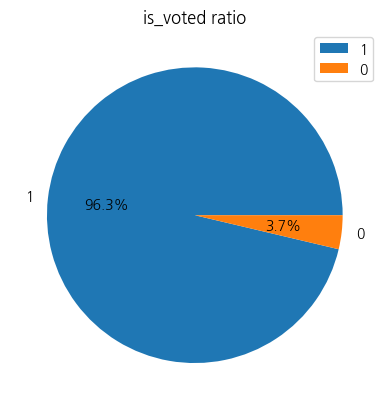

In [39]:
# polls_questionpiece -> is_voted 비율
fig, ax = plt.subplots()
# fig.patch.set_facecolor('none')
ax.pie(is_voted['count'], labels=is_voted['is_voted'], autopct='%1.1f%%',)
ax.legend()
plt.title('is_voted ratio')
plt.show()

In [ ]:
is_skipped = polls_questionpiece['is_skipped'].value_counts().reset_index()

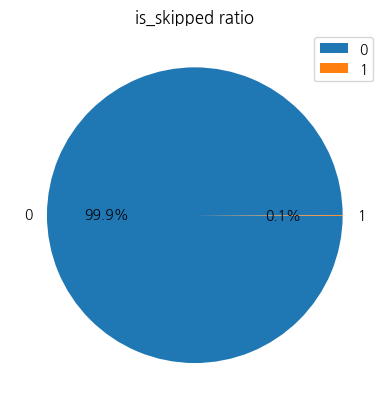

In [40]:
# polls_questionpiece -> is_skipped 비율
fig, ax = plt.subplots()
# fig.patch.set_facecolor('none')
ax.pie(is_skipped['count'], labels=is_skipped['is_skipped'], autopct='%1.1f%%',)
ax.legend()
plt.title('is_skipped ratio')
plt.show()

In [ ]:
gcs_parquet_path = "gs://sprintda05_final_project/votes/polls_questionset.parquet"
polls_questionset = pd.read_parquet(gcs_parquet_path, engine='pyarrow').drop(columns='id')

In [37]:
poll_status = polls_questionset['status'].value_counts().reset_index()
poll_status

,status,count
0,F,153411
1,O,4407
2,C,566


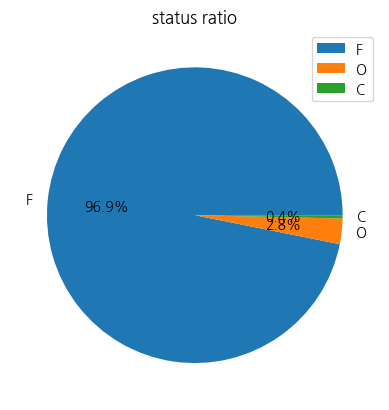

In [42]:
fig, ax = plt.subplots()
# fig.patch.set_facecolor('none')
ax.pie(poll_status['count'], labels=poll_status['status'], autopct='%1.1f%%',)
ax.legend()
plt.title('status ratio')
plt.show()

In [44]:
gcs_parquet_path = "gs://sprintda05_final_project/votes/polls_questionset.parquet"
polls_questionset = pd.read_parquet(gcs_parquet_path, engine='pyarrow').drop(columns='id')

In [ ]:
polls_questionset['created_at']

,question_piece_id_list,opening_time,status,created_at,user_id
0,"[998458, 998459, 998460, 998461, 998462, 99846...",2023-04-28 12:27:22,F,2023-04-28 12:27:23,849436
1,"[998588, 998589, 998590, 998591, 998592, 99859...",2023-04-28 12:28:07,F,2023-04-28 12:28:07,849438
2,"[998689, 998691, 998693, 998695, 998697, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,847375
3,"[998688, 998690, 998692, 998694, 998696, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,849446
4,"[998768, 998769, 998770, 998771, 998772, 99877...",2023-04-28 12:28:57,F,2023-04-28 12:28:57,849477
...,...,...,...,...,...
158379,"[208383291, 208383292, 208383293, 208383294, 2...",2024-05-05 14:46:27,C,2024-05-05 14:06:27,1251933
158380,"[208384201, 208384202, 208384203, 208384204, 2...",2024-05-06 11:38:20,C,2024-05-06 10:58:20,876072
158381,"[208384951, 208384952, 208384953, 208384954, 2...",2024-05-07 00:55:00,C,2024-05-07 00:15:00,1208878
158382,"[208385211, 208385212, 208385213, 208385214, 2...",2024-05-07 12:09:08,C,2024-05-07 11:29:08,1001607


In [47]:
created_at = polls_questionset['created_at'].value_counts().reset_index()

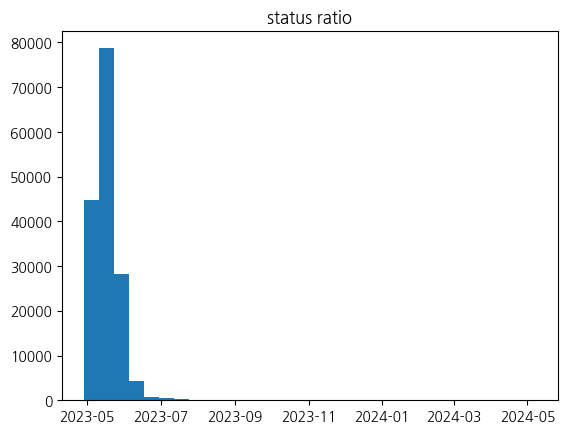

In [54]:
fig, ax = plt.subplots()
# fig.patch.set_facecolor('none')
ax.hist(polls_questionset['created_at'], bins=30)
plt.title('status ratio')
plt.show()

In [55]:
polls_questionset['created_at']

0        2023-04-28 12:27:23
1        2023-04-28 12:28:07
2        2023-04-28 12:28:38
3        2023-04-28 12:28:38
4        2023-04-28 12:28:57
                 ...        
158379   2024-05-05 14:06:27
158380   2024-05-06 10:58:20
158381   2024-05-07 00:15:00
158382   2024-05-07 11:29:08
158383   2024-05-07 11:32:30
Name: created_at, Length: 158384, dtype: datetime64[ns]